<a href="https://colab.research.google.com/github/faizuddin/IBB31103/blob/main/nlp_using_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to AI (IBB31103)
## Communication and Perception: Deep Learning for Natural Language Processing
In this tutorial, we will look into how to implement a pipeline that combines a traditional supervised learning algorithm with a deep learning algorithm to train labeled text data. Hence, the main objective is going to be to demonstrate how to set up that pipeline that facilitates collection, preprocessing and classifying labeled text data to finally training and evaluating deep learning models in [Keras](https://keras.io).

Specifically we will do the following:

1.   Download data from UCI Machine Learning Repository
2.   Read and clean up the dataset with `Pandas`.
4.   Preprocess text data using basic NLP techniques and generate features.
5.   Define baseline model.
6.   Train, compile, fit and evaluate deep learning models in `Keras`.





In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip

--2021-11-18 04:08:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘sentiment labelled sentences.zip’

sentiment labelled  100%[===================>]  82.21K  --.-KB/s    in 0.1s    

2021-11-18 04:08:53 (835 KB/s) - ‘sentiment labelled sentences.zip’ saved [84188/84188]



In [2]:
!unzip "sentiment labelled sentences.zip"

Archive:  sentiment labelled sentences.zip
   creating: sentiment labelled sentences/
  inflating: sentiment labelled sentences/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/sentiment labelled sentences/
  inflating: __MACOSX/sentiment labelled sentences/._.DS_Store  
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  
  inflating: sentiment labelled sentences/imdb_labelled.txt  
  inflating: __MACOSX/sentiment labelled sentences/._imdb_labelled.txt  
  inflating: sentiment labelled sentences/readme.txt  
  inflating: __MACOSX/sentiment labelled sentences/._readme.txt  
  inflating: sentiment labelled sentences/yelp_labelled.txt  
  inflating: __MACOSX/._sentiment labelled sentences  


In [3]:
import pandas as pd

filepath_dict = {'yelp':   "sentiment labelled sentences/yelp_labelled.txt",
                 'amazon': "sentiment labelled sentences/amazon_cells_labelled.txt",
                 'imdb':   "sentiment labelled sentences/imdb_labelled.txt"}

df_list = []

# read from directory above
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    # Add another column filled with the source name
    df['source'] = source  
    df_list.append(df)

df = pd.concat(df_list)

In [6]:
# The first 5 rows
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


## Baseline Model
We are going to define a simple model, which is then used as a comparison with the more advanced models that you want to test. In this case, we’ll use the baseline model based on BOW model to vectorize the sentences and compare it performance with our neural networks (later).

In [7]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.3, random_state=1000)

### Features Extraction
You can see that the resulting feature vectors have `700` samples which are the number of training samples we have after the train-test split. Each sample has `2505` dimensions which is the size of the vocabulary. Also, you can see that we get a sparse matrix. This is a data type that is optimised for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

`CountVectorizer` performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. 

We also can use a custom tokenizer from the NLTK library with the `CountVectorizer` or use any number of the customizations which you can explore to improve the performance of your model (refer to previous tutorial).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# "View" training features
X_train

<700x1665 sparse matrix of type '<class 'numpy.int64'>'
	with 6898 stored elements in Compressed Sparse Row format>

### Logistic
Classification using Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8033333333333333


### Random Forest
Classification using Random Forest

In [10]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.78


In [11]:
# Install Keras
!pip install keras

### Enabling and testing the GPU
First, you'll need to enable GPUs for the notebook:

*   Navigate to Edit→Notebook Settings
*   Select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [12]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Keras
Keras supports two main types of models:

1.   Sequential
2.   Functional

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

In this exercise, we will use Sequential model.

In [13]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Configure learning process
Specify the optimiser and the loss function.

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                16660     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 16,671
Trainable params: 16,671
Non-trainable params: 0
_________________________________________________________________


### Training
Since the training in neural networks is an iterative process, the training won’t just stop after it is done. You have to specify the number of iterations you want the model to be training. Those completed iterations are commonly called **epochs**. We want to run it for `100` epochs to be able to see how the training loss and accuracy are changing after each epoch.

Another parameter you have to your selection is the **batch** size. The batch size is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size.

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


### Clearing session
Note that if you rerun the `.fit()` method, you’ll start off with the computed weights from the previous training. Make sure to call `clear_session()` before you start training the model again.

In [16]:
from keras.backend import clear_session
clear_session()

### Evaluation

In [17]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7933


In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Training accuracy and loss
You can see that we have trained our model for too long since the training set reached `100%` accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around `20-40` epochs in this training.

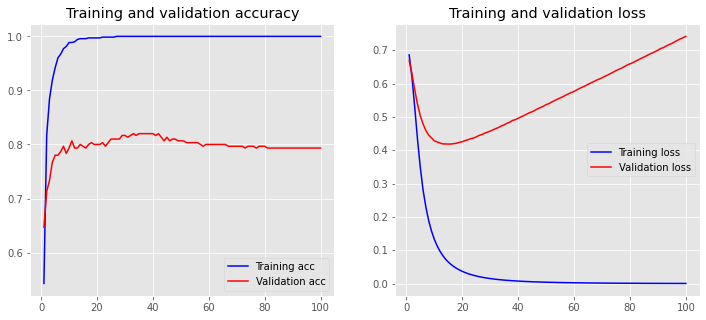

In [19]:
plot_history(history)